In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['font.size'] = 7
plt.rcParams['font.family'] = 'Arial'


annotations = pd.read_csv('../data_tables/erg_annos.tsv',sep = '\t', index_col='var_id')
gxe = pd.read_csv('../data_tables/ergosterol_pathway_gxe_interactions.tsv', sep = '\t')
var_fits = pd.read_csv('../data_tables/Fitness_files/ergosterol_pathway_fitness.tsv', sep = '\t')
annotated_gxe = gxe.merge(annotations,'inner','var_id')
annotated_fits = var_fits.merge(annotations,'inner','var_id')


In [2]:
def get_GxE_vars(annotated_gxe_df, annotated_fitness_df):
    '''This code generates the list of GxE variants based on our stringent two-part definition:
    1) the variant has a GxE term with FDR<0.01, and 2) for that term, the direction
    of effect in the two conditions is in opposite directions.
    inputs:
        annotated_gxe_df (pandas DataFrame): table containing pairwise GxE coefficients and pvalues for variants,
        annotated by genomic location.
        annotated_fitness_df (pandas DataFrame):  table containing fitness values for variants in 
        all relevant conditions,annotated by genomic location.
    returns:
        gxe_vars (list of strings): list of variants which show GxE according to our definition 
        (not unique, many represented multiple times) 
    '''
    gxe_vars =[] 
    for i, row in annotated_gxe_df[(annotated_gxe_df['padj']<0.01)].iterrows():
        var = row['var_id']
        conds = row['gxe'].split('-')
        if annotated_fitness_df[(annotated_fitness_df['var_id']==var)&\
                                (annotated_fitness_df['condition'].isin(conds))]['coef'].prod()<0:
            gxe_vars.append(var)
    return gxe_vars

In [3]:
annotated_fits['num_conds'] = annotated_fits.groupby('var_id')['coef'].transform('size')
hit_in_one_cond = annotated_fits[(annotated_fits['num_conds']==6)&(annotated_fits['padj']<.01)]['var_id'].unique()

In [4]:
gxe_vars = get_GxE_vars(annotated_gxe,annotated_fits)

In [5]:
len(hit_in_one_cond)

205

In [6]:
len(set(gxe_vars))

256

In [7]:
#Fraction of variants with fitness effects showing GxE
not_gxe =set(hit_in_one_cond)-set(gxe_vars)
1-len(not_gxe)/len(hit_in_one_cond)

0.9365853658536585

In [8]:
#calculating the fraction of variants with significant fitness effects in each 
#pair of conditions which show GxE between those conditions.

conditions = annotated_fits['condition'].unique().tolist()
fracs = []
for i,cond1 in enumerate(conditions):
    for cond2 in conditions[i+1:]:
        if cond1!=cond2:
            cond1cond2 = annotated_fits[annotated_fits.condition.isin([cond1,cond2])]
            #getting all variants with a significan fitness effect in either condition
            hitscond1cond2 = cond1cond2[(cond1cond2['padj']<.01)].var_id.unique()
            #Generating possible GxE term names
            gxe_possibilities = [cond1+'-'+cond2,cond2+'-'+cond1]
            #getting variants showing GxE term p-values with FDR<0.01 between the two conditions
            gxe_hits = annotated_gxe[(annotated_gxe['gxe'].isin(gxe_possibilities))&(annotated_gxe['padj']<.01)].var_id.unique()
            #getting the fitness effects of each of the fitness affecting variants in the two conditions
            hits_all = annotated_fits[(annotated_fits['var_id'].isin(hitscond1cond2))&(annotated_fits.condition.isin([cond1,cond2]))]
            #only keeping variants with measurements in both conditions
            hits_all['num_conds'] = hits_all.groupby('var_id')['var_id'].transform('size')
            hits_all = hits_all[hits_all['num_conds']==2]
            
            #getting the number of variants with significant fitness effects in these 2 conditions
            num_hits = hits_all.var_id.nunique()
            
            #checking to see if the fitness effects are in opposite directions, as is required
            #for our GxE definition. Product will be negative if there is a sign change.
            hits_all['signchange'] = hits_all.groupby('var_id')['coef'].transform('prod')
            
            #getting the number of variants with significant fitness effects with GxE in these two conditions
            gxe_c1c2 = hits_all[(hits_all['signchange']<0)&(hits_all['var_id'].isin(gxe_hits))]['var_id'].unique().tolist()
            
            #calculating the fraction of fitness affecting variants showing GxE in these 2 conditions
            frac  = len(gxe_c1c2)/num_hits
            fracs.append(frac)
           



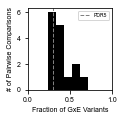

In [10]:
plt.subplots(figsize= (1.5,1.5))
plt.hist(fracs,bins = 5, color = 'black');

plt.xlabel('Fraction of GxE Variants', fontsize = 7)
plt.axvline(0.29230769230769227, c = 'grey',linestyle = 'dashed', linewidth = 1)
plt.xlim([0,1])
plt.legend(['PDR5'], fontsize = 5)
plt.ylabel('# of Pairwise Comparisons')
plt.savefig('../GxE_Figures/Figure_4/fig4f_pairwiseconcordance_FC.svg')

In [11]:
#fraction of variants showing GxE if all conditions 
#had the same fraction of GxE as PDR5 caffeine and fluconazole
1-(1-0.29230769230769227)**5

0.8224901834400324